In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-5udrz7ya
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-5udrz7ya
  Resolved https://github.com/tensorflow/examples.git to commit fed63294c10c71b7da028e0e75de9ff68ac56d17
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1741282361.1454860421494433302046033067432040489300359736599-py3-none-any.whl size=301643 sha256=2c0c345022e38752e5d4760e8247aaf7084c60468ee66549d34bae3c4445c667
  Stored in directory: /tmp/pip-ephem-wheel-cache-v5lo34ne/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [79]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

In [80]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 1024
IMG_HEIGHT = 1024

In [81]:
trainDisease_dir = "/kaggle/input/riceleafdataset/RiceLeafsDisease/train/brown_spot"
trainHealthy_dir = "/kaggle/input/riceleafdataset/RiceLeafsDisease/train/healthy"
testDisease_dir = "/kaggle/input/riceleafdataset/RiceLeafsDisease/validation/brown_spot"
testHealthy_dir = "/kaggle/input/riceleafdataset/RiceLeafsDisease/validation/healthy"

# Function to load and decode images
def load_and_decode_image(image_path):
    image = tf.io.read_file(image_path)  # Read image file
    image = tf.image.decode_png(image, channels=3)  # Decode as RGB tensor
    return image

# Function to create dataset with image tensors
def load_image_dataset(directory):
    file_paths = tf.data.Dataset.list_files(os.path.join(directory, "*.jpg"), shuffle=True)
    return file_paths.map(load_and_decode_image)  # Decode images

# Create tf.data datasets with image tensors
train_Disease = load_image_dataset(trainDisease_dir)  # Corresponds to trainA
train_Healthy = load_image_dataset(trainHealthy_dir)  # Corresponds to trainB
test_Disease = load_image_dataset(testDisease_dir)  # Corresponds to testA
test_Healthy = load_image_dataset(testHealthy_dir)  # Corresponds to testB

print("Datasets loaded successfully!")

# Debug: Print shape of one sample image
for img in train_Disease.take(1):
    print("Sample image shape:", img.shape)

Datasets loaded successfully!
Sample image shape: (1600, 1600, 3)


In [86]:
def random_crop(image):
  print("5-->", image.shape)
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  print("6-->", cropped_image.shape)
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  print("4-->", image.shape)
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  print("*-->", image.shape)
  return image

def random_jitter(image):
  print("3-->", image.shape)
  image = tf.image.resize(image, [IMG_HEIGHT+50, IMG_WIDTH+50],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)
  print("7-->", image.shape)
  return image

def preprocess_image_train(image):
  print("2-->", image.shape)
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  # image = random_crop(image)
  return image

In [83]:
train_Disease = train_Disease.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_Healthy = train_Healthy.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_Disease = test_Disease.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_Healthy = test_Healthy.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

2--> (None, None, 3)
3--> (None, None, 3)
5--> (1074, 1074, 3)
6--> (1024, 1024, 3)
7--> (1024, 1024, 3)
4--> (1024, 1024, 3)
*--> (1024, 1024, 3)
2--> (None, None, 3)
3--> (None, None, 3)
5--> (1074, 1074, 3)
6--> (1024, 1024, 3)
7--> (1024, 1024, 3)
4--> (1024, 1024, 3)
*--> (1024, 1024, 3)
4--> (None, None, 3)
*--> (None, None, 3)
4--> (None, None, 3)
*--> (None, None, 3)


In [84]:
sample_Disease = next(iter(train_Disease))
sample_Healthy = next(iter(train_Healthy))

3--> (1024, 1024, 3)
5--> (1074, 1074, 3)
6--> (1024, 1024, 3)
7--> (1024, 1024, 3)


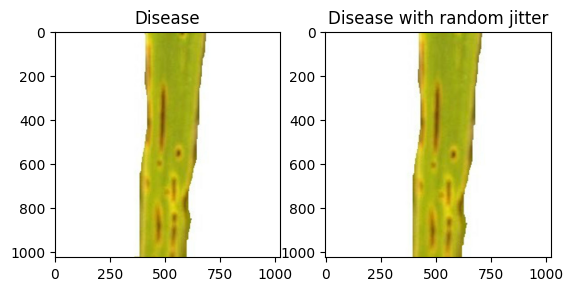

In [85]:
plt.subplot(121)
plt.title('Disease')
plt.imshow(sample_Disease[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Disease with random jitter')
plt.imshow(random_jitter(sample_Disease[0]) * 0.5 + 0.5)

3--> (1024, 1024, 3)
5--> (1074, 1074, 3)
6--> (1024, 1024, 3)
7--> (1024, 1024, 3)


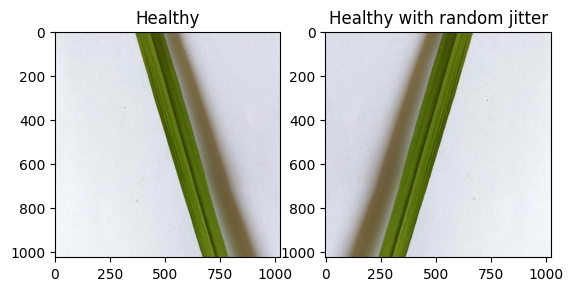

In [87]:
plt.subplot(121)
plt.title('Healthy')
plt.imshow(sample_Healthy[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Healthy with random jitter')
plt.imshow(random_jitter(sample_Healthy[0]) * 0.5 + 0.5)

In [88]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [89]:
print("sample_Healthy shape:", sample_Healthy.shape)
print("sample_Disease shape:", sample_Disease.shape)

sample_Healthy shape: (1, 1024, 1024, 3)
sample_Disease shape: (1, 1024, 1024, 3)


In [90]:
to_Healthy = generator_g(sample_Disease)
to_Disease = generator_f(sample_Healthy)

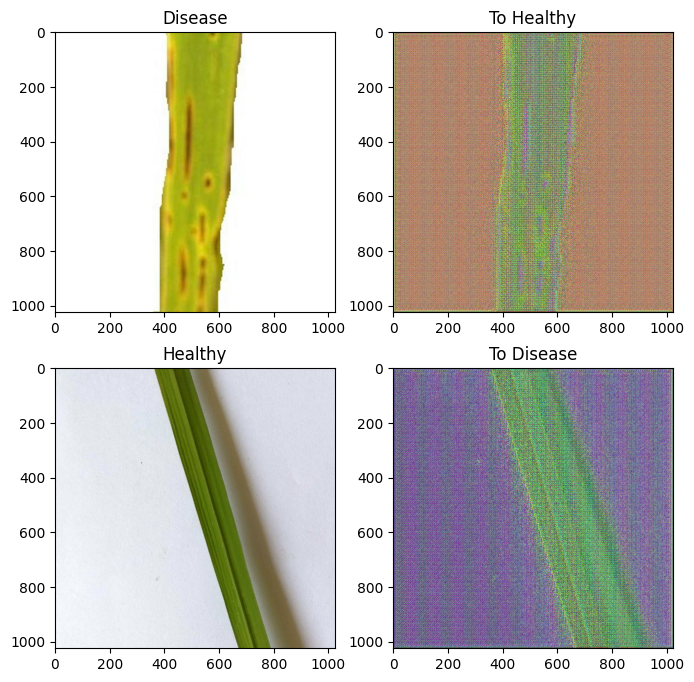

In [91]:
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_Disease, to_Healthy, sample_Healthy, to_Disease]
title = ['Disease', 'To Healthy', 'Healthy', 'To Disease']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [92]:
LAMBDA = 5 #changed from 10

In [93]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [94]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [95]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [96]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [97]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [99]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, clipnorm=1.0)

In [100]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [101]:
EPOCHS = 400

In [102]:
def generate_images(model, test_input):
    prediction = model(test_input)  # Get the generated image
    
    display_list = [test_input[0], prediction[0]]  # Keep the original and predicted image
    title = ['Input Image', 'Predicted Image']

    # Plot images (optional, for visualization)
    plt.figure(figsize=(12, 12))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)  # Rescale to [0, 1] for display
        plt.axis('off')
    plt.show()

    return prediction[0]  # Return the generated image so it can be saved


In [103]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

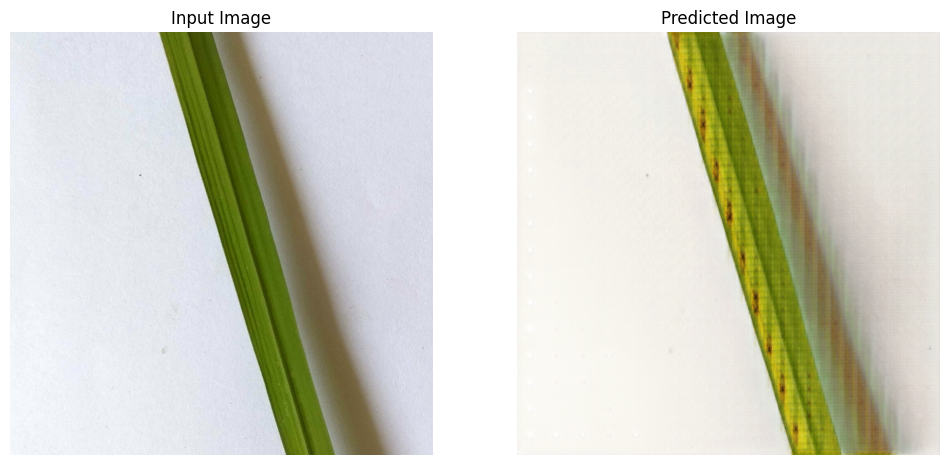

Time taken for epoch 2 is 785.4616622924805 sec

..........

In [ ]:
from PIL import Image

# Define directory inside Kaggle's working directory
output_dir = "./generated_images"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_Disease, train_Healthy)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print('.', end='')
        n += 1

    clear_output(wait=True)

    # Generate images
    generated_image = generate_images(generator_f, sample_Healthy)

    # Convert to NumPy array and scale values (assuming range [-1, 1])
    generated_image_np = np.array((generated_image[0] + 1) * 127.5, dtype=np.uint8)  # Scale to [0, 255]
    image_pil = Image.fromarray(generated_image_np)

    # Save image in the output directory
    image_filename = os.path.join(output_dir, f"epoch_{epoch+1}.png")
    image_pil.save(image_filename)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

    print(f'Time taken for epoch {epoch+1} is {time.time()-start} sec\n')

print(f"All generated images are saved in {output_dir}. You can download them from the Kaggle notebook.")

In [ ]:
for inp in test_Healthy.take(5):
    print("Original input shape:", inp.shape)  # Likely (1, 1600, 1600, 3)

    # Resize before feeding into generator
    resized_inp = tf.image.resize(inp, [256, 256])
    print("Resized input shape:", resized_inp.shape)  # Should now be (1, 256, 256, 3)

    generate_images(generator_f, resized_inp)

In [76]:
# generator_g.save('generator_g.h5')  # Noisy → Clear
generator_f.save('generator_f_with-1024.h5')  # Clear → Noisy (if applicable)
print("Models saved successfully!")

Models saved successfully!


Original input shape: (1, 1600, 1600, 3)
Resized input shape: (1, 256, 256, 3)


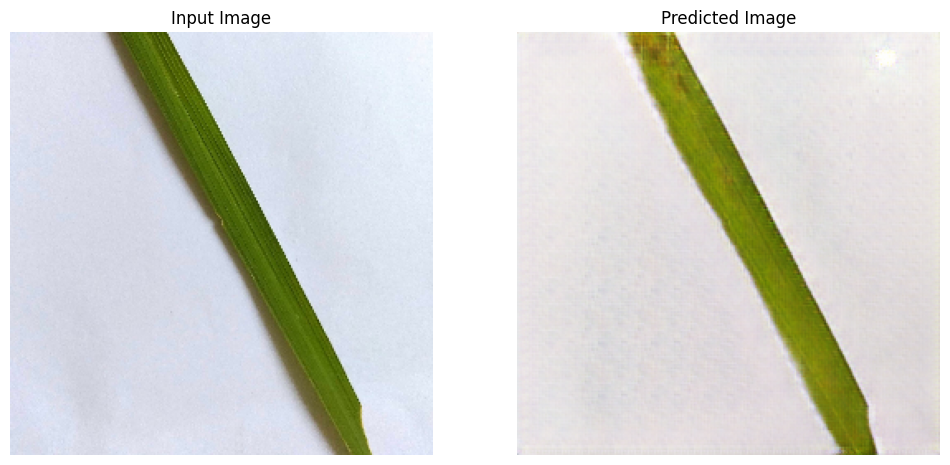

Original input shape: (1, 1600, 1600, 3)
Resized input shape: (1, 256, 256, 3)


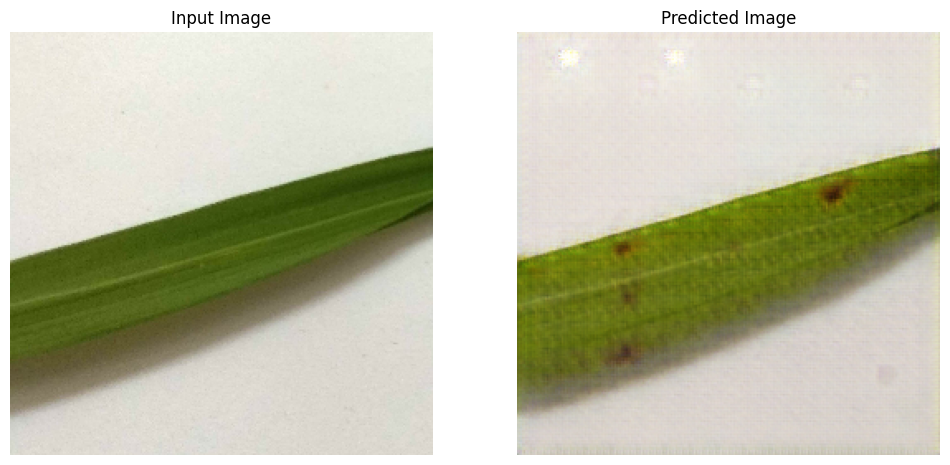

Original input shape: (1, 1600, 1600, 3)
Resized input shape: (1, 256, 256, 3)


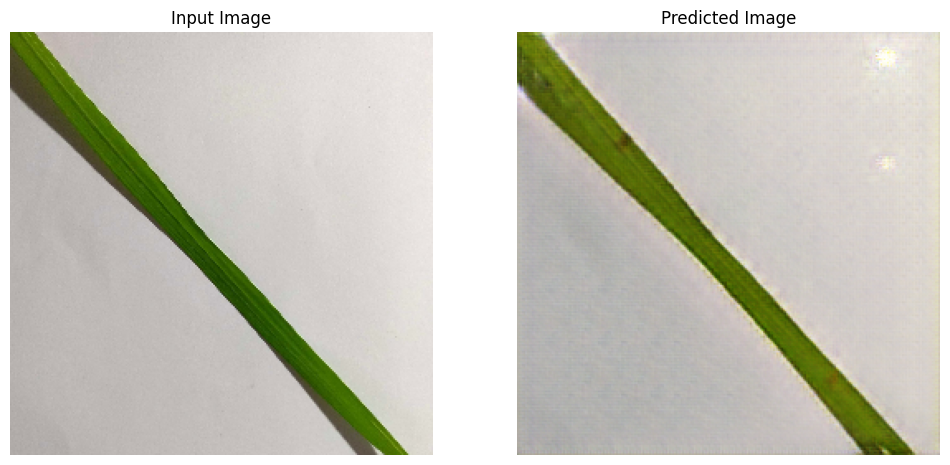

Original input shape: (1, 1600, 1600, 3)
Resized input shape: (1, 256, 256, 3)


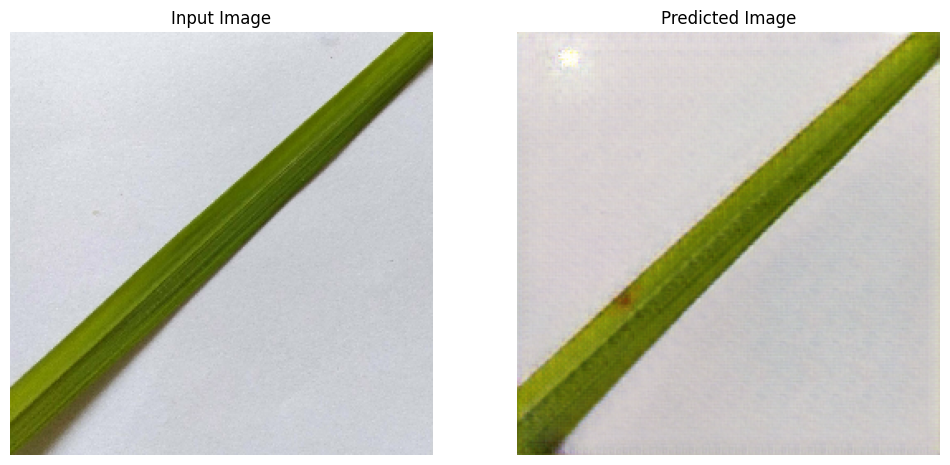

Original input shape: (1, 1600, 1600, 3)
Resized input shape: (1, 256, 256, 3)


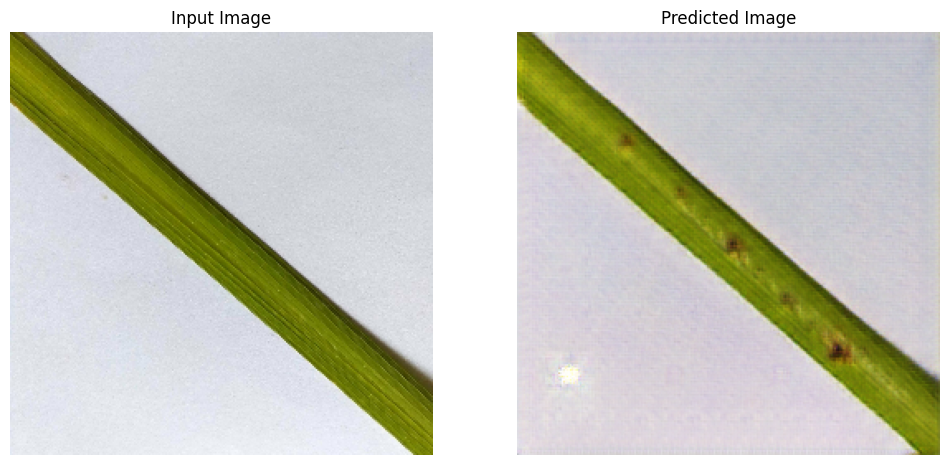

In [78]:
for inp in test_Healthy.take(5):
    print("Original input shape:", inp.shape)  # Likely (1, 1600, 1600, 3)

    # Resize before feeding into generator
    resized_inp = tf.image.resize(inp, [256, 256])
    print("Resized input shape:", resized_inp.shape)  # Should now be (1, 256, 256, 3)

    # generate_images(generator_f, resized_inp)
    high_res_output = tf.image.resize(generate_images(generator_f, resized_inp), [1024, 1024], method='bicubic')